In [1]:
# Parameters
# Refer to injected parameters for any run.ipynb (similar cell below)
compound = "anidulafungin"

# Notebook to predict intrinsic resistance conferred by Hotspot 1 sequences found in Fks homologs



Initially written by M. Giguere and adapted by R. Durand with bits from F.D. Rouleau, this notebook imports an [optimized Random Forest Classifier](./random_forest.ipynb) and uses it to do predictions. We then display performance metrics and explain the decisions with SHAP values.

## Import libraries

In [2]:
import pandas as pd
import numpy as np

np.bool = np.bool_
np.int = np.int_

from sklearn.metrics import (
    balanced_accuracy_score,
    classification_report,
    confusion_matrix,
    roc_auc_score,
    matthews_corrcoef,
    roc_curve,
)
from sklearn.preprocessing import StandardScaler
import shap

import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams["svg.fonttype"] = "none"
from matplotlib import cm

import pickle

## Specify paths

In [3]:
### Input
model_path = f"../ML/{compound}_model.pkl"
data = "../classified/BY4741_FKS1-HS1/refined_classification_ortho.csv"
aa_properties = "../../general_data/aminoAcidProperties.txt"

phylo_path = "../../general_data/fks_phylo.txt"

### Output
outpath = "../ML/"

## Import model

In [4]:
with open(model_path, "rb") as m:
    model = pickle.load(m)
model

,n_estimators,300
,criterion,'gini'
,max_depth,10
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


## Import amino acid properties

In [5]:
df_aa_prop = pd.read_table(aa_properties).rename(columns={"Aminoacid.1.letter": "aa"})
df_aa_prop

,aa,alpha_helix_chou,alpha_helix_deleage,alpha_helix_levitt,aminoacid_composition_swissprot_bairoch,antiparallel_beta_strand_lifson,average_area_buried_folding_rose,average_flexibility_bhaskaran,average_surrounding_hydrophobicity_manavalan,beta_sheet_chou,...,recognition_factors,refractivity,relative_mutability_ala100_dayhoff,retention_coefficient_hfba_browne,retention_coefficient_ph2.1_meek,retention_coefficient_ph7.4_meek,retention_coefficient_tfa_browne,total_beta_strand_lifson,transmembrane_tendency_zhao,levy_propensity
0,A,1.42,1.489,1.29,8.25,0.90,86.6,0.36,12.97,0.83,...,78,4.34,100,3.9,-0.1,0.5,7.3,0.92,0.38,0.0062
1,C,0.70,0.966,1.11,1.37,1.24,132.3,0.35,14.63,1.19,...,89,35.77,20,-14.3,-2.2,-6.8,-9.2,1.16,-0.30,1.0372
2,D,1.01,0.924,1.04,5.45,0.47,97.8,0.51,10.85,0.54,...,81,12.00,106,-2.8,-2.8,-8.2,-2.9,0.48,-3.27,-0.7485
3,E,1.51,1.504,1.44,6.75,0.62,113.9,0.50,11.89,0.37,...,78,17.26,102,-7.5,-7.5,-16.9,-7.1,0.61,-2.90,-0.7893
4,F,1.13,1.195,1.07,3.86,1.23,194.1,0.31,14.00,1.38,...,81,29.40,41,14.7,13.9,13.2,19.2,1.25,1.98,1.2727
5,G,0.57,0.510,0.56,7.07,0.56,62.9,0.54,12.43,0.75,...,84,0.00,49,-2.3,-0.5,0.0,-1.2,0.61,-0.19,-0.1771
6,H,1.00,1.003,1.22,2.27,1.12,155.8,0.32,12.16,0.87,...,84,21.81,66,2.0,0.8,-3.5,-2.1,0.93,-1.44,0.1204
7,I,1.08,1.003,0.97,5.96,1.54,158.0,0.46,15.67,1.60,...,88,19.06,96,11.0,11.8,13.9,6.6,1.81,1.97,1.1109
8,K,1.16,1.172,1.23,5.84,0.74,115.5,0.47,11.36,0.74,...,87,21.29,56,-2.5,-3.2,0.1,-3.7,0.70,-3.46,-1.1806
9,L,1.21,1.236,1.30,9.66,1.26,164.1,0.37,14.90,1.30,...,85,18.78,40,15.0,10.0,8.8,20.0,1.30,1.82,0.9138


## Reshape dataframe for predictions

In [6]:
all_comp = pd.read_csv(data)

# Restrict to selected drug
df = (
    all_comp[all_comp.compound == compound][["compound", "aa_seq", "sensres"]]
    .copy()
    .rename(columns={"sensres": "resistance"})
    .groupby(["compound", "aa_seq"])[["resistance"]]
    .first()
    .reset_index()
)
print(len(df.aa_seq.unique()))

49


In [7]:
# Explode aa_seq into many columns
list_pos = np.arange(639, 648)
wtaa_cols = [f"aa{x}" for x in list_pos]
df[wtaa_cols] = df["aa_seq"].apply(lambda x: pd.Series(list(x)))

In [8]:
# Merge dataframe with AAproperties
merged = df.copy()

for i in list_pos:
    AA = df_aa_prop.set_index("aa").add_suffix(f"_aa{i}")
    AA.index.name = f"aa{i}"
    merged = pd.merge(
        left=merged,
        right=AA.reset_index(),
        how="inner",
        suffixes=(None, f"_aa{i}"),
        on=f"aa{i}",
    )

merged

,compound,aa_seq,resistance,aa639,aa640,aa641,aa642,aa643,aa644,aa645,...,recognition_factors_aa647,refractivity_aa647,relative_mutability_ala100_dayhoff_aa647,retention_coefficient_hfba_browne_aa647,retention_coefficient_ph2.1_meek_aa647,retention_coefficient_ph7.4_meek_aa647,retention_coefficient_tfa_browne_aa647,total_beta_strand_lifson_aa647,transmembrane_tendency_zhao_aa647,levy_propensity_aa647
0,anidulafungin,AICSDLRED,resistant,A,I,C,S,D,L,R,...,81,12.00,106,-2.8,-2.8,-8.2,-2.9,0.48,-3.27,-0.7485
1,anidulafungin,ALALNIKDP,sensitive,A,L,A,L,N,I,K,...,91,10.93,56,5.6,8.0,6.1,5.1,0.40,-1.44,-0.1799
2,anidulafungin,ALTLSFRDP,resistant,A,L,T,L,S,F,R,...,91,10.93,56,5.6,8.0,6.1,5.1,0.40,-1.44,-0.1799
3,anidulafungin,FLALNLSDS,resistant,F,L,A,L,N,L,S,...,107,6.35,120,-3.5,-3.7,1.2,-4.1,0.82,-0.53,0.1376
4,anidulafungin,FLALSFKDP,sensitive,F,L,A,L,S,F,K,...,91,10.93,56,5.6,8.0,6.1,5.1,0.40,-1.44,-0.1799
5,anidulafungin,FLALSFRDA,resistant,F,L,A,L,S,F,R,...,78,4.34,100,3.9,-0.1,0.5,7.3,0.92,0.38,0.0062
6,anidulafungin,FLALSFRDP,sensitive,F,L,A,L,S,F,R,...,91,10.93,56,5.6,8.0,6.1,5.1,0.40,-1.44,-0.1799
7,anidulafungin,FLALSIRDP,sensitive,F,L,A,L,S,I,R,...,91,10.93,56,5.6,8.0,6.1,5.1,0.40,-1.44,-0.1799
8,anidulafungin,FLIKSLIDP,sensitive,F,L,I,K,S,L,I,...,91,10.93,56,5.6,8.0,6.1,5.1,0.40,-1.44,-0.1799
9,anidulafungin,FLILSLRDP,sensitive,F,L,I,L,S,L,R,...,91,10.93,56,5.6,8.0,6.1,5.1,0.40,-1.44,-0.1799


In [9]:
merged[["compound", "aa_seq", "resistance"]].to_csv(
    f"{outpath}/{compound}_testing.csv", index=False
)

In [10]:
cols_of_interest = [x for x in merged.columns if "_aa" in x]
All_ortho_x = merged[cols_of_interest]
All_ortho_x

,alpha_helix_chou_aa639,alpha_helix_deleage_aa639,alpha_helix_levitt_aa639,aminoacid_composition_swissprot_bairoch_aa639,antiparallel_beta_strand_lifson_aa639,average_area_buried_folding_rose_aa639,average_flexibility_bhaskaran_aa639,average_surrounding_hydrophobicity_manavalan_aa639,beta_sheet_chou_aa639,beta_sheet_deleage_aa639,...,recognition_factors_aa647,refractivity_aa647,relative_mutability_ala100_dayhoff_aa647,retention_coefficient_hfba_browne_aa647,retention_coefficient_ph2.1_meek_aa647,retention_coefficient_ph7.4_meek_aa647,retention_coefficient_tfa_browne_aa647,total_beta_strand_lifson_aa647,transmembrane_tendency_zhao_aa647,levy_propensity_aa647
0,1.42,1.489,1.29,8.25,0.90,86.6,0.36,12.97,0.83,0.709,...,81,12.00,106,-2.8,-2.8,-8.2,-2.9,0.48,-3.27,-0.7485
1,1.42,1.489,1.29,8.25,0.90,86.6,0.36,12.97,0.83,0.709,...,91,10.93,56,5.6,8.0,6.1,5.1,0.40,-1.44,-0.1799
2,1.42,1.489,1.29,8.25,0.90,86.6,0.36,12.97,0.83,0.709,...,91,10.93,56,5.6,8.0,6.1,5.1,0.40,-1.44,-0.1799
3,1.13,1.195,1.07,3.86,1.23,194.1,0.31,14.00,1.38,1.393,...,107,6.35,120,-3.5,-3.7,1.2,-4.1,0.82,-0.53,0.1376
4,1.13,1.195,1.07,3.86,1.23,194.1,0.31,14.00,1.38,1.393,...,91,10.93,56,5.6,8.0,6.1,5.1,0.40,-1.44,-0.1799
5,1.13,1.195,1.07,3.86,1.23,194.1,0.31,14.00,1.38,1.393,...,78,4.34,100,3.9,-0.1,0.5,7.3,0.92,0.38,0.0062
6,1.13,1.195,1.07,3.86,1.23,194.1,0.31,14.00,1.38,1.393,...,91,10.93,56,5.6,8.0,6.1,5.1,0.40,-1.44,-0.1799
7,1.13,1.195,1.07,3.86,1.23,194.1,0.31,14.00,1.38,1.393,...,91,10.93,56,5.6,8.0,6.1,5.1,0.40,-1.44,-0.1799
8,1.13,1.195,1.07,3.86,1.23,194.1,0.31,14.00,1.38,1.393,...,91,10.93,56,5.6,8.0,6.1,5.1,0.40,-1.44,-0.1799
9,1.13,1.195,1.07,3.86,1.23,194.1,0.31,14.00,1.38,1.393,...,91,10.93,56,5.6,8.0,6.1,5.1,0.40,-1.44,-0.1799


In [11]:
All_ortho_y = merged["resistance"]
All_ortho_y

0     resistant
1     sensitive
2     resistant
3     resistant
4     sensitive
5     resistant
6     sensitive
7     sensitive
8     sensitive
9     sensitive
10    resistant
11    resistant
12    resistant
13    resistant
14    sensitive
15    sensitive
16    sensitive
17    sensitive
18    sensitive
19    sensitive
20    sensitive
21    sensitive
22    resistant
23    sensitive
24    sensitive
25    sensitive
26    resistant
27    sensitive
28    resistant
29    resistant
30    resistant
31    resistant
32    resistant
33    resistant
34    resistant
35    resistant
36    resistant
37    resistant
38    resistant
39    resistant
40    resistant
41    resistant
42    resistant
43    resistant
44    resistant
45    resistant
46    resistant
47    resistant
48    resistant
Name: resistance, dtype: object

## Get predictions

In [12]:
# Scale
scaler = StandardScaler()
scaler.fit(All_ortho_x)
X_test_s = pd.DataFrame(scaler.transform(All_ortho_x), columns=All_ortho_x.columns)

In [13]:
y_test = All_ortho_y

In [14]:
test_pred = model.predict(X_test_s)

# Predict class of test set
test_pred = model.predict(X_test_s)  # test_pred previously y_pred

# Predict class probability of test set
test_pred_prob = model.predict_proba(X_test_s)

In [15]:
proba_df = pd.DataFrame(data=test_pred_prob[::, 1])
proba_df.to_csv(f"{outpath}/{compound}_ROCproba.csv", index=False)

### Display performance

In [16]:
# Display performance metrics

print(
    "Balanced accuracy: %0.1f %%\n\n"
    % (100 * balanced_accuracy_score(y_test, test_pred))
)
print(classification_report(y_test, test_pred))

cm_test = confusion_matrix(y_test, test_pred)
our_cm = cm_test
TN = our_cm[0, 0]
TP = our_cm[1, 1]
FN = our_cm[1, 0]
FP = our_cm[0, 1]
acc = round((TP + TN) / np.sum(our_cm), 2)  # accuracy
tpr = round(TP / (TP + FN), 2)  # true positive rate, sensitivity, recall
tnr = round(TN / (TN + FP), 2)  # true negative rate, specificity
ppv = round(TP / (TP + FP), 2)  # positive predictive value, precision
npv = round(TN / (TN + FN), 2)  # negative predictive value
print(f"Test set - Accuracy: {acc}, TPR: {tpr}, TNR: {tnr}, PPV: {ppv}, NPV: {npv}")

Balanced accuracy: 84.1 %


              precision    recall  f1-score   support

   resistant       0.88      0.90      0.89        31
   sensitive       0.82      0.78      0.80        18

    accuracy                           0.86        49
   macro avg       0.85      0.84      0.84        49
weighted avg       0.86      0.86      0.86        49

Test set - Accuracy: 0.86, TPR: 0.78, TNR: 0.9, PPV: 0.82, NPV: 0.88


### Export predictions

In [17]:
export_df = pd.DataFrame(data=[y_test, test_pred])
export_df = export_df.T
export_df.rename(columns={"resistance": "y_test"}, inplace=True)
export_df.rename(columns={"Unnamed 0": "y_pred"}, inplace=True)

In [18]:
export_df.to_csv(f"{outpath}/{compound}_ML_results.csv", index=False)

### What was misclassified?

In [19]:
taxdf = pd.read_csv(phylo_path, sep="\t")[
    ["Kingdom", "Phylum", "Species", "Hotspot1", "Is_Human_Pathogen"]
]
merged_pred = pd.concat(
    [merged[["aa_seq", "resistance"]], export_df[["y_pred"]]], axis=1
)
fullmerged = taxdf.rename(columns={"Hotspot1": "aa_seq"}).merge(
    right=merged_pred, on="aa_seq"
)
display(
    fullmerged[fullmerged.resistance != fullmerged.y_pred]
    .groupby("aa_seq")[["resistance", "y_pred", "Species"]]
    .agg(
        resistance=("resistance", "first"),
        y_pred=("y_pred", "first"),
        Species=("Species", "unique"),
    )
)
fullmerged.to_csv(f"{outpath}/{compound}_ML_results_merged.csv", index=False)

,resistance,y_pred,Species
aa_seq,,,
ALALNIKDP,sensitive,resistant,[Dactylellina haptotyla]
FLSLSFRDP,resistant,sensitive,"[Schizosaccharomyces japonicus, Schizosaccharo..."
FLTHSFRDP,resistant,sensitive,[Polytolypa hystricis]
FLTLSFENP,sensitive,resistant,"[Sporobolomyces roseus, Melampsora larici-popu..."
FLTLSFRDT,sensitive,resistant,[Diaporthe ampelina]
FLVLSLRDP,sensitive,resistant,[Saccharomyces cerevisiae]
FMALSLRDP,resistant,sensitive,[Meyerozyma guilliermondii]


## SHAP

In [20]:
## Re-compute SHAP values
# Create SHAP explainer for the trained model (brf) and calculate SHAP values for the test data (X_test_s)
explainer = shap.TreeExplainer(model)
shap_v = explainer(X_test_s)

## Extract SHAP values and reshape df
# Create DataFrames for SHAP values and original data
shap_df = pd.DataFrame(shap_v.values[:, :, 0])
data = pd.DataFrame(shap_v.data)
columns = X_test_s.columns
shap_df.columns = columns
data.columns = columns

In [21]:
# Function to normalize a column to the range [0, 1]
def min_max_scaling(column):
    min_val = column.min()
    max_val = column.max()
    if min_val == max_val:
        return column
    else:
        return (column - min_val) / (max_val - min_val)


# Apply min-max scaling to each column in the original data DataFrame
data = data.apply(min_max_scaling)

In [22]:
# Reshape SHAP values DataFrame and original data DataFrame for plotting
shap_long = shap_df.melt(var_name="Features", value_name="Shap values")
data_long = data.melt(var_name="Features", value_name="Data")
# Concatenate SHAP values and original data for plotting
df = pd.concat([shap_long, data_long["Data"]], axis=1)

# Select specific columns for the final strip plot. Using the most important features. Most important Features (mif)
fi = df
fi["Shap values"] = fi["Shap values"].abs()
feature_importance = fi.groupby(["Features"], as_index=False).mean()
feature_importance.sort_values(by=["Shap values"], ascending=False, inplace=True)
mif = feature_importance[0:4]["Features"].to_list()
print(mif)

['alpha_helix_levitt_aa639', 'retention_coefficient_hfba_browne_aa646', 'alpha_helix_chou_aa639', 'alpha_helix_deleage_aa639']


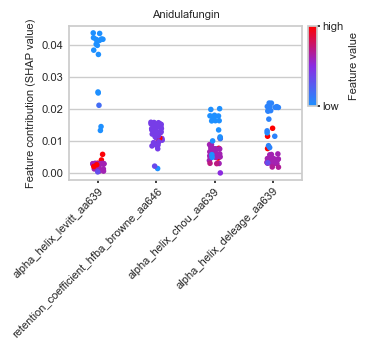

In [23]:
# Graph options
rc_dict = {
    "figure.figsize": (3, 2),
    "font.family": "Arial",
    "font.size": 8,
    "legend.title_fontsize": 8,
    "legend.fontsize": 8,
    "axes.labelsize": 8,
    "axes.titlesize": 8,
    "xtick.labelsize": 8,
    "ytick.labelsize": 8,
    "xtick.major.pad": 2,
    "ytick.major.pad": 2,
    "xtick.bottom": True,
    "ytick.left": False,
    "xtick.major.size": 2,
    "ytick.major.size": 2,
}
sns.set(rc=rc_dict, style="whitegrid")

ccmap = sns.color_palette(
    "blend:dodgerblue,blueviolet,red", as_cmap=True  # SHAP default cmap
)

# Create a strip plot for selected columns using SHAP values and original data
fig = sns.stripplot(
    data=df[df["Features"].isin(mif)],
    x="Features",
    y="Shap values",
    hue="Data",
    legend=False,
    jitter=True,
    palette=ccmap,
    size=4,
    order=mif,
)

fig.set(xlabel="", ylabel="Feature contribution (SHAP value)")
plt.xticks(rotation=45, ha="right", rotation_mode="anchor")

fig.set_title(f"{compound.title()}")

# Custom colorbar
norm_Data = plt.Normalize(0, 1)
sm = cm.ScalarMappable(cmap=ccmap, norm=norm_Data)
sm.set_array([])
cax = plt.axes([0.92, 0.48, 0.03, 0.4])  # left bottom width height
cbar = plt.colorbar(sm, cax=cax)
cbar.ax.set_ylabel("Feature value")
cbar.ax.set_yticks([0, 1], ["low", "high"])

plt.savefig(f"{outpath}/{compound}_SHAP.svg", format="svg", dpi=300)